# Defining a dataset
I am using this one https://www.kaggle.com/competitions/it1244-brain-tumor-dataset

In [1]:
import FileIO
include("./data.jl")
include("./transforms.jl")

# create the dataset from all files in a folder, label function gets the last folder in path
ds = DatasetLabeled()

DatasetLabeled(Sample[], Any[])

`data.csv` looks like
```csv
76,benign
77,benign
155,malignant
156,malignant
...
```

In [2]:
path = "D:/datasets/it1244-brain-tumor-dataset/data"

# define the loader
# it reads the file, resizes to 256,256, converts to flux-compatible array and ensures 3 channels
# I had to add `ToChannels(3)` to my loader since most images in the dataset have 3 channels, but a few have 1.
loader = Compose(FileIO.load, Resize(256, 256), to_image_arr, ToChannels(3))

# add all samples
open("$path/train/data.csv") do f
    while !eof(f)
        num, label = split(replace(readline(f), "\ufeff" => ""), ",")
        add_sample!(ds, "$path/train/$num.jpg", loader=loader, label=label)
    end
end

ds.classes

2-element Vector{Any}:
 "benign"
 "malignant"

In [3]:
# show all samples
[i.sample for i in ds.samples][1:4]

4-element Vector{String}:
 "D:/datasets/it1244-brain-tumor-dataset/data/train/17.jpg"
 "D:/datasets/it1244-brain-tumor-dataset/data/train/18.jpg"
 "D:/datasets/it1244-brain-tumor-dataset/data/train/19.jpg"
 "D:/datasets/it1244-brain-tumor-dataset/data/train/20.jpg"

Indexing into a dataset returns a tuple: `(WHC array, one-hot encoded label)`

In [4]:
ds[1]

(Float32[0.0 0.03529412 … 0.007843138 0.007843138; 0.019607844 0.011764706 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.050980393 0.050980393 … 0.047058824 0.047058824;;; 0.16078432 0.20392157 … 0.2 0.2; 0.19607843 0.18039216 … 0.2 0.2; … ; 0.015686275 0.015686275 … 0.023529412 0.023529412; 0.09019608 0.09019608 … 0.09803922 0.09803922;;; 0.42352942 0.4627451 … 0.35686275 0.35686275; 0.42745098 0.4117647 … 0.38431373 0.38431373; … ; 0.0 0.0 … 0.0 0.0; 0.047058824 0.047058824 … 0.03137255 0.03137255], Bool[1, 0])

In [5]:
# size of the image array
size(ds[1][1])

(256, 256, 3)

In [6]:
# one-hot encoded label vector
ds[1][2]

2-element OneHotVector(::UInt32) with eltype Bool:
 1
 ⋅

We can compute the channel-wise mean and standard deviation of the entire dataset using `mean_std`. 

This function supports arbitrary number of dimensions, as long as all samples are channel-last and have the same dimensions and channels.

In [7]:
# Compute mean and std of dataset in 32-element batches for efficiency.
meanstd = mean_std(ds, 16)

([0.2470104314627186, 0.2472696626378644, 0.24763014912605286], [0.2395324658962988, 0.23959763972989975, 0.23977934497018014])

Now we can add a Normalize transform to our dataset using `add_loader!`, which adds a new function to the end of the pipeline.

In [8]:
add_loader!(ds, Normalize(meanstd))
ds.samples[1].loader

Compose((FileIO.load, Resize((256, 256)), to_image_arr, ToChannels(3), Normalize([0.2470104314627186, 0.2472696626378644, 0.24763014912605286], [0.2395324658962988, 0.23959763972989975, 0.23977934497018014])))

Since we don't have a lot of images, we can significantly speed up the training by preloading them all into RAM using `preload!`

In [9]:
    preload!(ds)
    ds[1]

(Float32[-1.031219 -0.8838731 … -0.99847543 -0.99847543; -0.9493602 -0.9821037 … -1.031219 -1.031219; … ; -1.031219 -1.031219 … -1.031219 -1.031219; -0.8183861 -0.8183861 … -0.83475786 -0.83475786;;; -0.36096075 -0.18092036 … -0.19728768 -0.19728768; -0.21365498 -0.2791242 … -0.19728768 -0.19728768; … ; -0.9665512 -0.9665512 … -0.9338166 -0.9338166; -0.65557235 -0.65557235 … -0.6228377 -0.6228377;;; 0.7335881 0.8971371 … 0.4555547 0.4555547; 0.74994296 0.68452334 … 0.57003903 0.57003903; … ; -1.0327418 -1.0327418 … -1.0327418 -1.0327418; -0.83648294 -0.83648294 … -0.90190256 -0.90190256], Bool[1, 0])

Lets also split into train and test datasets ("test" folder in the dataset is actually a folder with unlabeled samples for submission, so we need to split the "train" folder dataset)

In [10]:
ds_train, ds_test = split_dataset(ds, 0.8)
length(ds_test)

1, 392
393, 98


98

Now we can create a DataLoader using MLUtils. Make sure to specify `collate = true`.

In [11]:
import MLUtils
dl_train = MLUtils.DataLoader(ds_train, batchsize=8, shuffle=true, collate=true)
dl_test = MLUtils.DataLoader(ds_test, batchsize=8, shuffle=false, collate=true)

13-element DataLoader(::DatasetLabeled, batchsize=8, collate=Val{true}())
  with first element:
  (256×256×3×8 Array{Float32, 4}, 2×8 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

Thats it! Time to use flux, so I defined simple CNN model (and did zero optimal architecture search for this as its a demo).

In [12]:
using Flux, CUDA, Statistics, ProgressMeter
model = Chain(
    Conv((5, 5), 3 => 12, gelu, bias=false), # 254?
    MaxPool((3, 3)), # 84?
    BatchNorm(12),
    Conv((3, 3), 12 => 16, gelu, bias=false), # 82?
    MaxPool((2, 2)), # 41?
    BatchNorm(16),
    Conv((3, 3), 16 => 24, gelu, bias=false), #39?
    MaxPool((2, 2)), # 19?
    BatchNorm(24),
    Conv((3, 3), 24 => 32, gelu, bias=false), #17?
    MaxPool((2, 2)), # 8?
    BatchNorm(32),
    Conv((3, 3), 32 => 40, gelu), # 6?
    Flux.flatten,
    Dense(40 * 6 * 6, length(ds.classes)),
) |> gpu

# pass one batch through it
batch = first(dl_train)
out1 = model(batch[1] |> gpu) |> cpu

2×8 Matrix{Float32}:
 0.0557466  0.078466    0.027881   …   0.0210702    0.0451681  0.0548385
 0.0212238  0.0357197  -0.0121348     -0.00247982  -0.0173762  0.00795082

And the training loop is copy-pasted from Flux docs, but I added testing on dl_test and accuracy

In [13]:
# Standard training loop works with our dataset out of the box
losses = []
accuracy = []
test_accuracy = []
optim = Flux.setup(OptimiserChain(WeightDecay(1e-2), ClipNorm(2), AdamW(3e-3)), model)
@showprogress for epoch in 1:10

    # train
    for (images, labels) in dl_train
        loss, grads = Flux.withgradient(model) do m
            # Evaluate model and loss inside gradient context:
            y_hat = m(images |> gpu)
            # Calculate accuracy
            Flux.ignore_derivatives() do
                push!(accuracy, mean(argmax(y_hat |> cpu, dims=1) .== argmax(labels, dims=1)))
            end
            Flux.logitcrossentropy(y_hat, labels |> gpu)
        end
        Flux.update!(optim, model, grads[1])
        push!(losses, loss)
    end

    #test
    test_accuracy_epoch = []
    for (images, labels) in dl_test
        y_hat = model(images |> gpu)
        push!(test_accuracy_epoch, mean(argmax(y_hat |> cpu, dims=1) .== argmax(labels, dims=1)))
    end
    push!(test_accuracy, mean(test_accuracy_epoch))

end

# pass one batch through the trained model
out1 = model(batch[1] |> gpu) |> cpu

Progress:  20%|█████████                                |  ETA: 0:05:49

Progress:  30%|█████████████                            |  ETA: 0:03:29

Progress:  40%|█████████████████                        |  ETA: 0:02:17

Progress:  50%|█████████████████████                    |  ETA: 0:01:33

Progress:  60%|█████████████████████████                |  ETA: 0:01:03

Progress:  70%|█████████████████████████████            |  ETA: 0:00:41

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:24

Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:11

Progress: 100%|█████████████████████████████████████████| Time: 0:01:40

2×8 Matrix{Float32}:
 -1.96711  -2.0508   -2.15789  -2.3147   …   2.27414   3.10905  -2.29171
  2.26004   2.07874   2.36686   2.55029     -2.59193  -2.551     2.4411

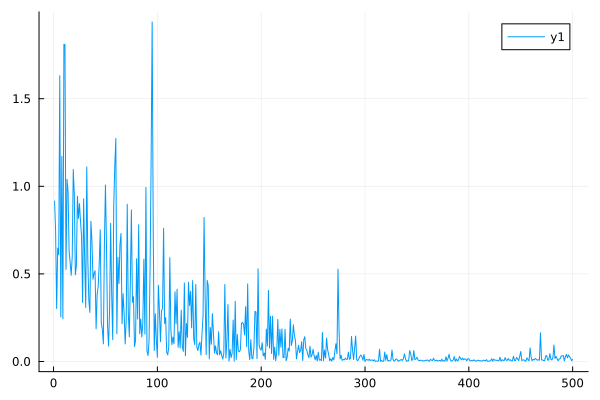

In [14]:
using Plots
plot(losses)

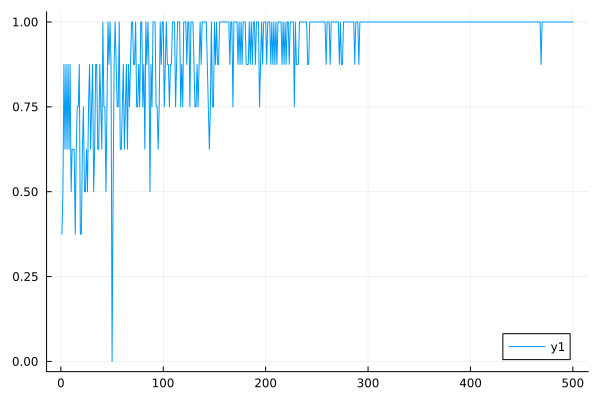

In [15]:
plot(accuracy)

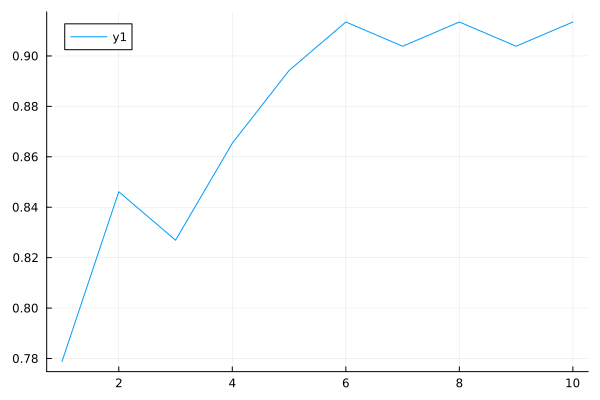

In [16]:
plot(test_accuracy)

In [17]:
test_accuracy

10-element Vector{Any}:
 0.7788461538461539
 0.8461538461538461
 0.8269230769230769
 0.8653846153846154
 0.8942307692307693
 0.9134615384615384
 0.9038461538461539
 0.9134615384615384
 0.9038461538461539
 0.9134615384615384